## AIDL  Deep Learning and Neural Networks
### Columbia University


# Assignment: Conditional GAN -- enlarge bottle challenge dataset

From last assignment, we built a CNN model to classify the amount of liquid in those bottles in the bottle challenge dataset. And we got around 95% accuracy as the final result which is pretty decent. If we want to push it even further, we should consider augmenting the dataset as one of the improvement.

In this assignment, we will use the conditional DCGAN model to generate bottle image with desired amount of liquid that we want.



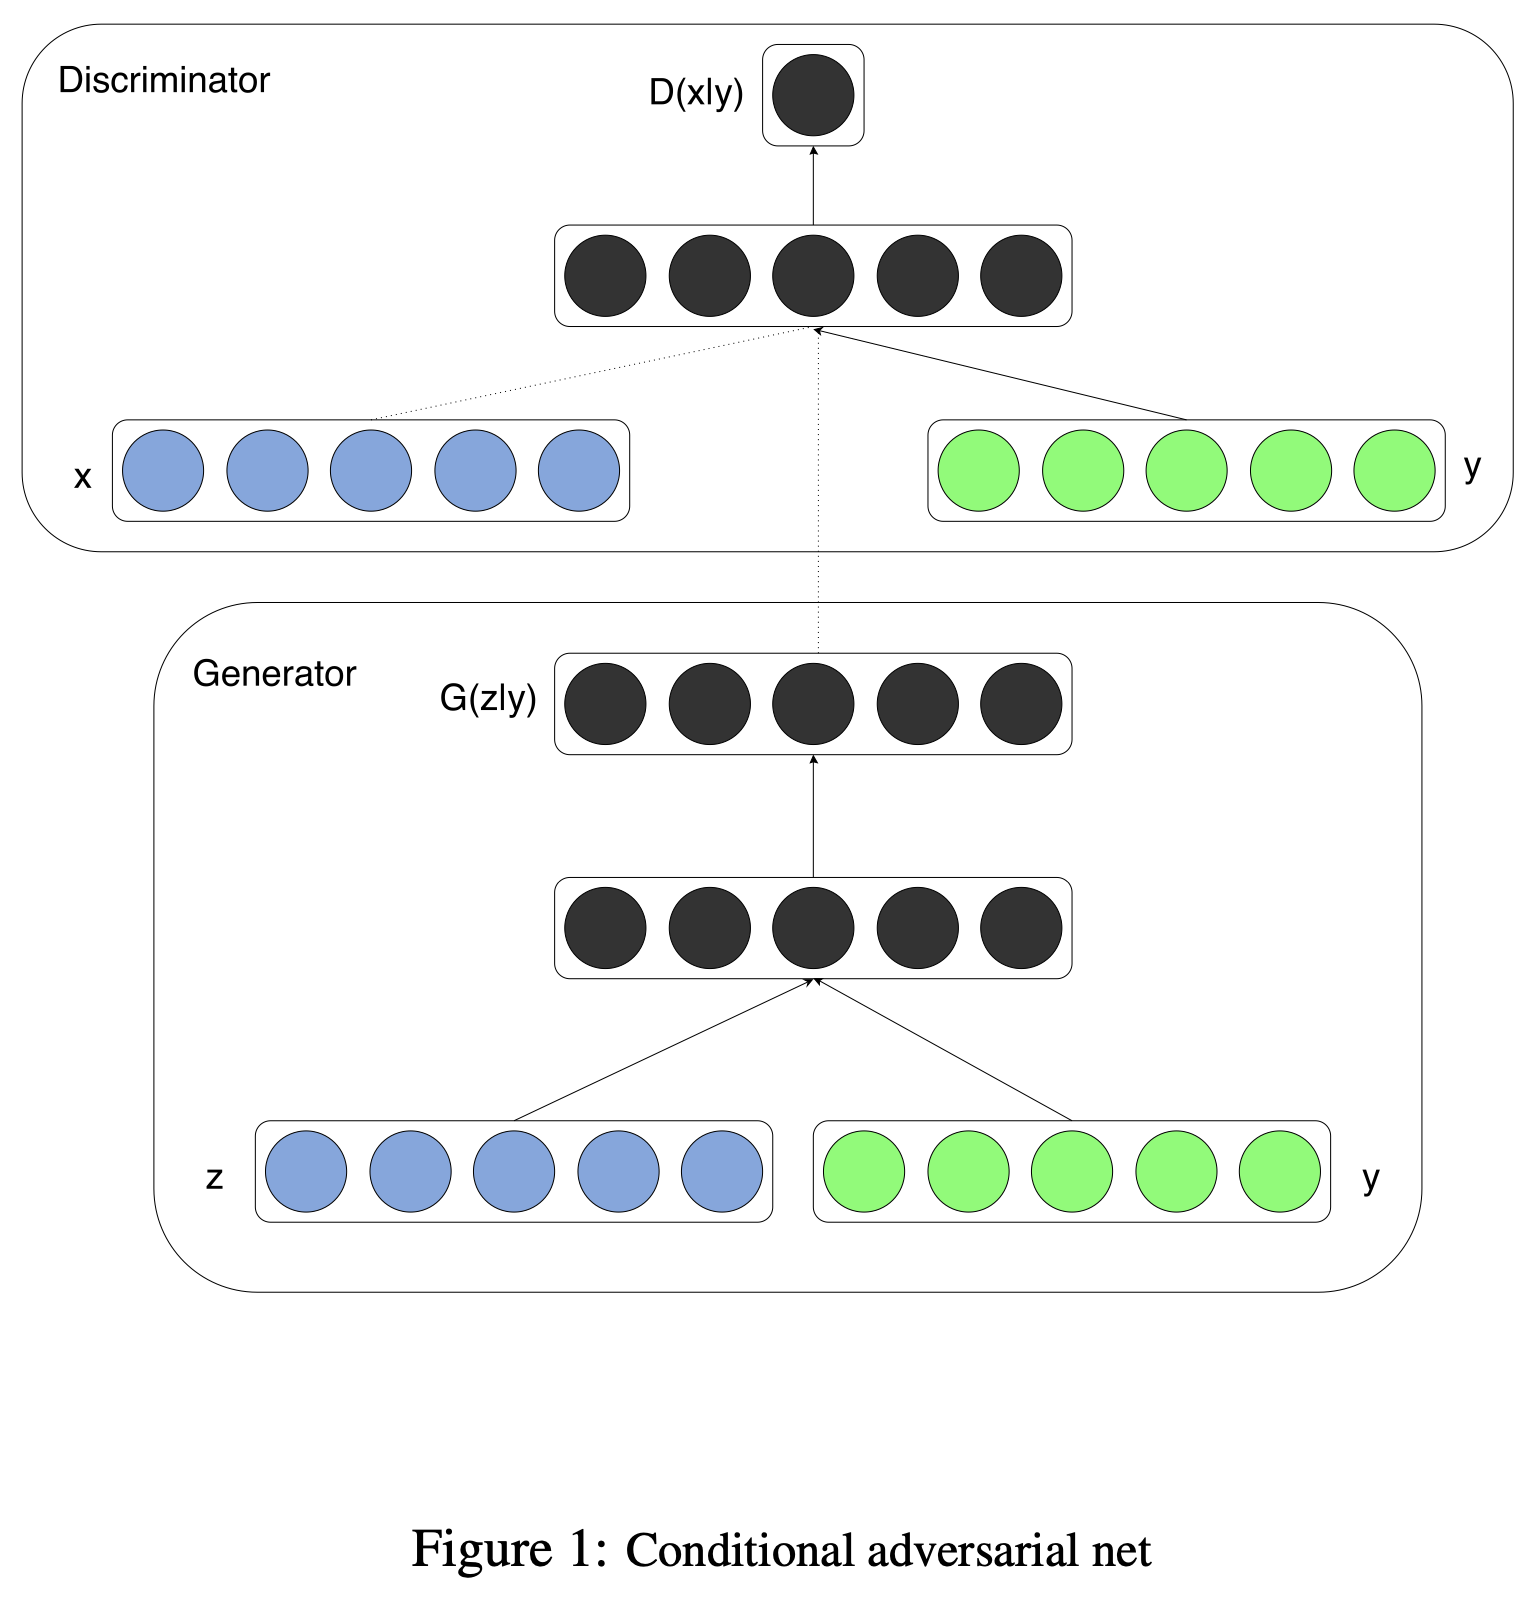

**References:**

**1. Conditional GAN paper:** https://arxiv.org/abs/1411.1784

**2. DCGAN paper:** https://arxiv.org/abs/1511.06434

**3. Keras Functional API tutorial:** https://keras.io/guides/functional_api/

**4. Keras Generate faces with DCGAN:** https://keras.io/examples/generative/dcgan_overriding_train_step/#dcgan-to-generate-face-images

**5. Tutorial of building conditional GAN with Keras:** https://machinelearningmastery.com/how-to-develop-a-conditional-generative-adversarial-network-from-scratch/

# **Important: Set GPU on Colab**

Unlike the previous assignments, training a GAN model is computationally intensive (there are two models training at the same time!). So we need to use the GPU (graphical processing unit) to train our model. Fortunately, Colab provide free GPU resource for us. Please follow the instruction before moving forward.

**Instruction:**

**1. Click Edit on the top tool bar**

**2. Click Notebook Settings**

**3. Click the Hardware Accelerator and choose "GPU"**

**4.Click Save button, it will restart Colab Runtime automatically**


## **Prepare bottle challenge dataset**

First of all, we need to prepare the bottle challenge dataset.

Start by uploading the presented .zip file with the dataset to your google drive, under AIDL_data/AIDL_Bottle_Challenge_Dataset.zip (From Assignment 4).


The bottle challenge dataset structure is:

- **train_128**: training directory contains 5 subfolders, each numper represents the percentage of the liquiid inside the bottle (0: empty,1: 25%,2:50%, 3:75%, 4:full bottle)
      -- 0: bottle is empty
      -- 1: bottle is 25% full
      -- 2: bottle is 50% full
      -- 3: bottle is 75% full
      -- 4: bottle is full
- **test_128**: test folder cotains 3000 images for test without any label

In this task, we will only need the training dataset to generate "new" images.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip -q drive/MyDrive/AIDL_data/AIDL_Bottle_Challenge_Dataset.zip -d data/

### Import essential packages

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os

### Prepare Bottle Data

To get the label information, we will choose bottle training set as our dataset.

In this assignment, we will downsample the image to (64,64,3) instead of (128,128,3).  This is due to the limited computation power that Google Colab can provide. If you have a more powerful GPU, you can modify the model structure to generate 128x128 images on your own.

In [4]:
train_dataset_path = './data/AIDL_Bottle_Challenge_Dataset/train_128/'
class_dataset = keras.preprocessing.image_dataset_from_directory(
    train_dataset_path, labels="inferred", image_size=(64, 64), batch_size=32
)
class_dataset = class_dataset.map(lambda x,y: (x / 255.0,y)) #map the rescaling function to ease the training convergence

Found 15000 files belonging to 5 classes.


### Visualize one sample from the dataset.

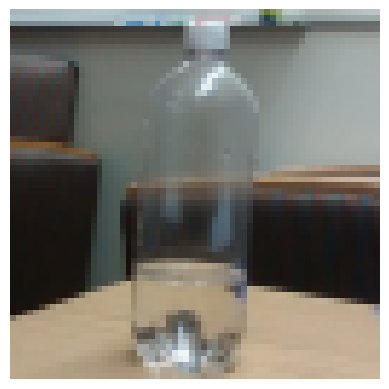

In [5]:
for x in class_dataset:
    plt.axis("off")
    plt.imshow((x[0].numpy()*255 ).astype("int32")[0])
    break

## **Build discriminator**

DCGAN has beautiful symmetrical generator-discriminator structures.
The discriminator structure consists of several convolution blocks to extract features from image. Then the feature map will be flatten and fully connected to generate the final prediction.

In this assignment, you will need to modify the original DCGAN discriminator structure to take both image and label as input. For multiple input/output purpose, the Keras **Sequential** strucuture is not a good choice. You need to use **Keras Functional API** to build the model.



**Discriminator Model Structure**



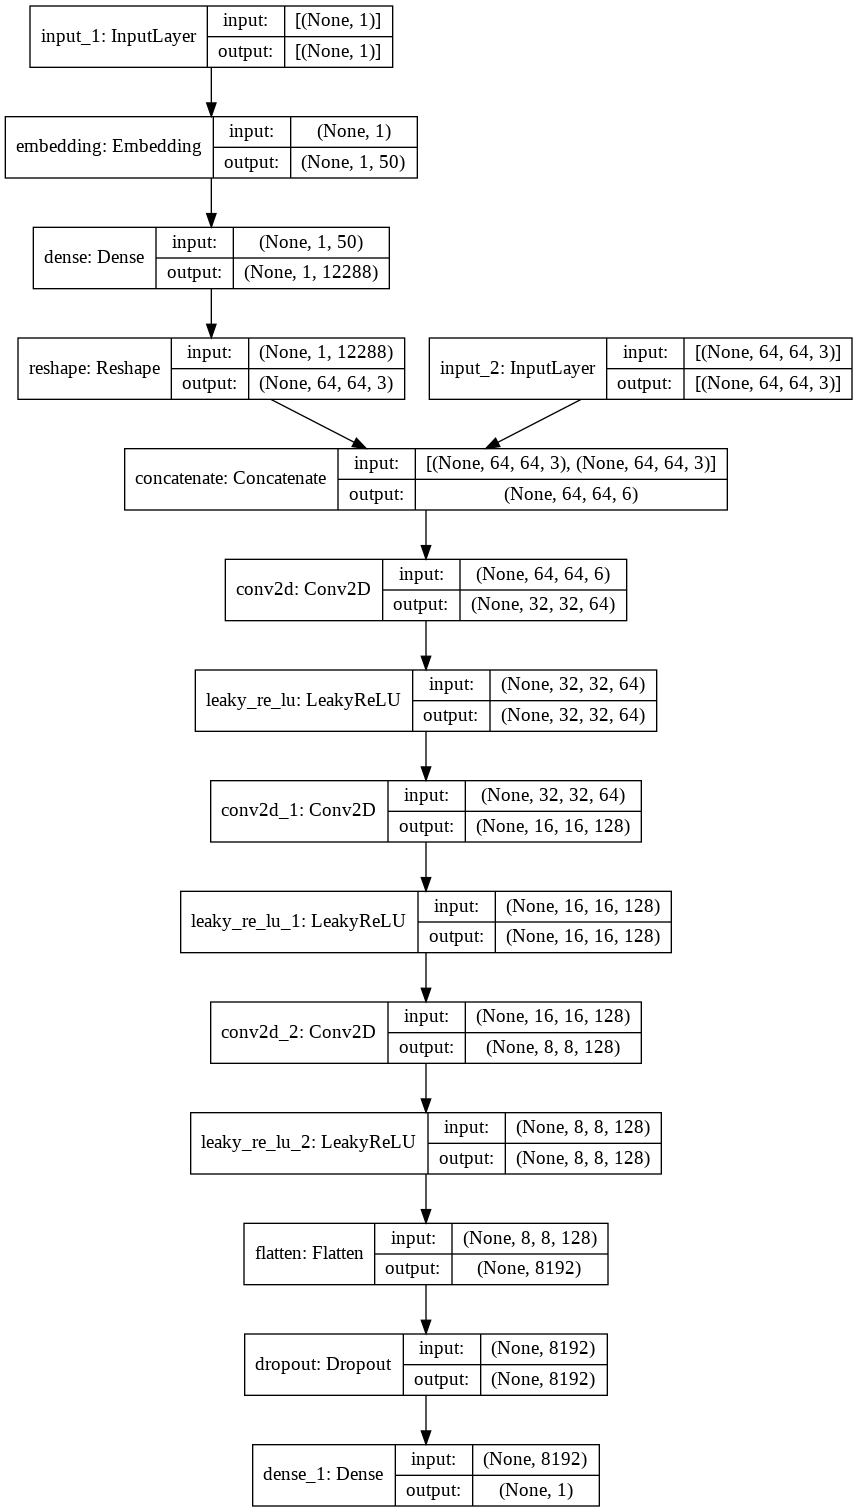



<span style="color:red"><strong>TODO</strong></span>: Check **layers** API and reproduce the model structure shown above (**You have to figure out several model parameters by yourself**). We have given you the skeleton code as the starting point.


**Important tips:**

(1) All the **Conv2D** layers have the same **kernel size=3, stride = 2, "same" padding**;

(2) all the **activation functions** are **"LeakyRelu"** with **leakage rate 0.2**;

(3) **Dropout** rate is **0.4**





**Reference:**


**1. Keras layers API:** https://keras.io/api/layers/


In [6]:
img_shape = (64,64,3) #input image shape
num_classes = 5      #number of classes
#begin model
in_label = layers.Input(shape=(1,)) #input for label
label_emb = layers.Embedding(num_classes,50)(in_label)
# %%%%%%%%%%%%%% implement your code below (13 lines) %%%%%%%%%%%%%%
#scale up embedding to image dimensions
num_nodes = img_shape[0] * img_shape[1]       #calculate the number of nodes
li = layers.Dense(num_nodes)(label_emb)             #scale up the label embedding
li = layers.Reshape((img_shape[0], img_shape[1], 1))(li)             # reshape to additional channel
in_image = layers.Input(shape=img_shape)       # image input
merge = layers.Concatenate()([in_image, li])          # concat label as a channel
# downsample block
fe = layers.Conv2D(64, kernel_size=3, strides=2, padding='same')(merge)            #Conv2D
fe = layers.LeakyReLU(alpha=0.2)(fe)             #LeakyRelu
# downsample
fe = layers.Conv2D(128, kernel_size=3, strides=2, padding='same')(fe)             #Conv2D
fe = layers.LeakyReLU(alpha=0.2)(fe)             #LeakyRelu
# downsample
fe = layers.Conv2D(256, kernel_size=3, strides=2, padding='same')(fe)            #Conv2D
fe = layers.LeakyReLU(alpha=0.2)(fe)             #LeakyRelu

fe = layers.Flatten()(fe)             # flatten feature maps

fe = layers.Dropout(0.4)(fe)            # dropout
# %%%%%%%%%%%%%% your code ends here %%%%%%%%%%%%%%
# output
out_layer = layers.Dense(1, activation='sigmoid')(fe)
# define model
discriminator = keras.models.Model([in_image, in_label], out_layer)
discriminator.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 1, 50)          │            250 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 1, 4096)        │        208,896 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 64, 64, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 64, 64, 1)      │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 64, 64, 4)      │              0 │ input_layer_1[0][0],   │
│                           │                        │                │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 32, 32, 64)     │          2,368 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu (LeakyReLU)   │ (None, 32, 32, 64)     │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 16, 16, 128)    │         73,856 │ leaky_re_lu[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_1 (LeakyReLU) │ (None, 16, 16, 128)    │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 8, 8, 256)      │        295,168 │ leaky_re_lu_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_2 (LeakyReLU) │ (None, 8, 8, 256)      │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 16384)          │              0 │ leaky_re_lu_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 16384)          │              0 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1)              │         16,385 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 596,923 (2.28 MB)

 Trainable params: 596,923 (2.28 MB)

 Non-trainable params: 0 (0.00 B)

## **Build Generator**

The generator structure is the "reverse" version of its discriminator, which consists of several Transpose convolution blocks to expand features from the latent code.

In this assignment, you will need to modify the original DCGAN generator structure to take both latent code and label as input. For multiple input/output purpose, the Keras **Sequential** strucuture is not a good choice. We will use **Keras Functional API** to build up our model.

**Generator Model Structure**

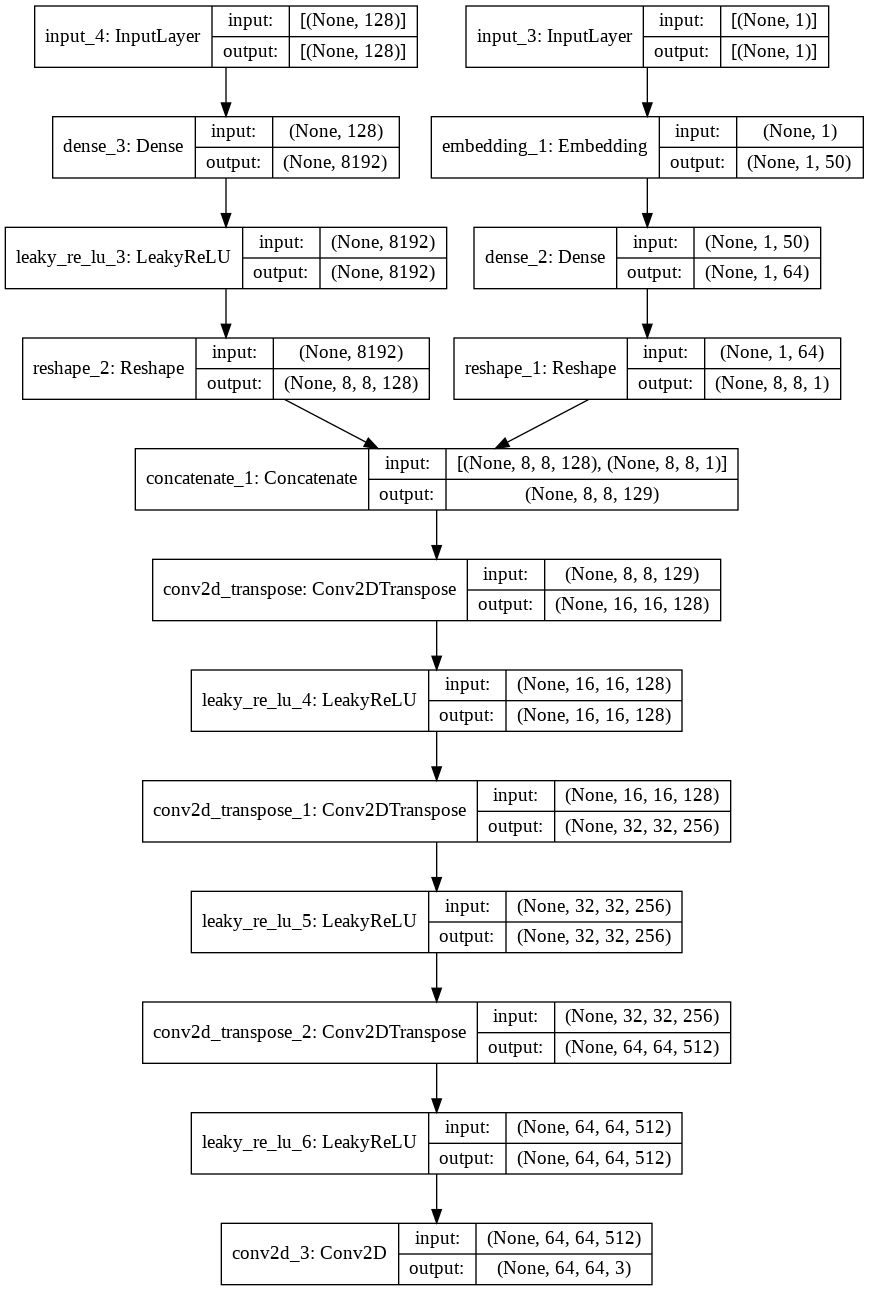



<span style="color:red"><strong>TODO</strong></span>: Check **layers** API and reproduce the model structure shown above (**You have to figure out several model parameters by yourself**). We have given you the skeleton code as the starting point.


**Important tips:**

(1) All the **Conv2DTranspose** layers have the same **kernel size=4, stride = 2, "same" padding**;

(2) all the **activation functions** are **"LeakyRelu"** with **leakage rate 0.2**;

**Reference:**


**1. Keras layers API:** https://keras.io/api/layers/


In [9]:
latent_dim = 128
#begin model
in_label = layers.Input(shape=(1,)) #input for label
label_emb = layers.Embedding(num_classes,50)(in_label) #embedding for label input
# %%%%%%%%%%%%%% implement your code below (15 lines) %%%%%%%%%%%%%%
# label input branch
num_nodes = 8 * 8  # 64 nodes for 8x8x1 shape
li = layers.Dense(num_nodes)(label_emb)  # linear multiplication for the label input
li = layers.Reshape((8, 8, 1))(li)  # reshape to additional channel
# image generator input
in_lat = layers.Input(shape=(latent_dim,))  # generate latent vector
# foundation for 8x8 image
num_img_nodes = 8 * 8 * 256  # 8x8 image with 256 channels
gen = layers.Dense(num_img_nodes)(in_lat)
gen = layers.LeakyReLU(alpha=0.2)(gen)
gen = layers.Reshape((8, 8, 256))(gen)
merge = layers.Concatenate()([gen, li])# concat label as a channel
# upsample to 16x16
gen = layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding='same')(merge)
gen = layers.LeakyReLU(alpha=0.2)(gen)
# upsample to 32x32
gen = layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding='same')(gen)
gen = layers.LeakyReLU(alpha=0.2)(gen)
# upsample to 64x64
gen = layers.Conv2DTranspose(32, kernel_size=4, strides=2, padding='same')(gen)
gen = layers.LeakyReLU(alpha=0.2)(gen)
# %%%%%%%%%%%%%% your code ends here %%%%%%%%%%%%%%
# output
out_layer = layers.Conv2D(3, (5,5), activation='tanh', padding='same')(gen)
# define model
generator = keras.models.Model([in_lat, in_label], out_layer)
generator.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 128)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_4             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 16384)          │      2,113,536 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_3 (Embedding)   │ (None, 1, 50)          │            250 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_3 (LeakyReLU) │ (None, 16384)          │              0 │ dense_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 1, 64)          │          3,264 │ embedding_3[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_4 (Reshape)       │ (None, 8, 8, 256)      │              0 │ leaky_re_lu_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_3 (Reshape)       │ (None, 8, 8, 1)        │              0 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 8, 8, 257)      │              0 │ reshape_4[0][0],       │
│ (Concatenate)             │                        │                │ reshape_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 16, 16, 128)    │        526,464 │ concatenate_1[0][0]    │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_4 (LeakyReLU) │ (None, 16, 16, 128)    │              0 │ conv2d_transpose[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_1        │ (None, 32, 32, 64)     │        131,136 │ leaky_re_lu_4[0][0]    │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_5 (LeakyReLU) │ (None, 32, 32, 64)     │              0 │ conv2d_transpose_1[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_2        │ (None, 64, 64, 32)     │         32,800 │ leaky_re_lu_5[0][0]    │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_6 (LeakyReLU) │ (None, 64, 64, 32)     │              0 │ conv2d_transpose_2[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 3)      │          2,403 │ leaky_re_lu_6[0][0]    │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,809,853 (10.72 MB)

 Trainable params: 2,809,853 (10.72 MB)

 Non-trainable params: 0 (0.00 B)

Check models input shapes

In [ ]:
generator.input

[<KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'input_35')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'input_34')>]

In [ ]:
discriminator.input

[<KerasTensor: shape=(None, 64, 64, 3) dtype=float32 (created by layer 'input_33')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'input_32')>]

## **Modify training schedule**

Unlike training image classifiers, training discriminator and gemnerator happens simultaneously. And they have interaction at each training step, which requires us to overide the original training step function in the Keras Model.




<span style="color:red"><strong>TODO</strong></span>: Check **train_step** function and create the correct model traininng function for Conditional GAN. We have given you the skeleton code as the starting point.


**Important tips:** This is the core of GAN model, we encourage you to fully understand the training procedure happening in CGAN before working on this assignment.


**Reference:**


**1. TF train_step:** https://www.tensorflow.org/api_docs/python/tf/keras/Model#train_step


In [11]:
class CGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(CGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(CGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, batch_data):
        real_images, real_labels = batch_data
        real_labels = tf.cast(real_labels, tf.float32)

        # Get batch size from batch_data
        batch_size = tf.shape(real_images)[0]
        # Generate random normal latent vectors
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Generate fake images
        generated_images = self.generator([random_latent_vectors, real_labels])

        # Combine real and fake images
        combined_images = tf.concat([generated_images, real_images], axis=0)
        # Combine labels for real and fake images
        combined_labels = tf.concat([real_labels, real_labels], axis=0)

        # Create labels for fake and real images (1 for fake, 0 for real)
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))],
            axis=0
        )

        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator([combined_images, combined_labels])
            d_loss = self.loss_fn(labels, predictions)

        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Generate new random latent vectors for generator training
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Create misleading labels (all zeros - "real" images)
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(
                [self.generator([random_latent_vectors, real_labels]), real_labels]
            )
            g_loss = self.loss_fn(misleading_labels, predictions)

        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

## Monitor training progress

In [12]:
temp_img_path ='./temp_img/'
if os.path.exists(temp_img_path):
  print('directory already exists')
else:
  os.mkdir(temp_img_path)

In [13]:
class CGANMonitor(keras.callbacks.Callback):
    def __init__(self, latent_dim=128):
        self.num_img = 5
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        label = tf.reshape(tf.constant([0,1,2,3,4],dtype=tf.float32),(5,1))
        generated_images = self.model.generator((random_latent_vectors,label))
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save(temp_img_path+"generated_img_%03d_%d.png" % (epoch, i))

## Train the GAN model

In [14]:
epochs = 100  # In practice, use ~100 epochs

cgan = CGAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
cgan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)
cgan.fit(
    class_dataset, epochs=epochs, callbacks=[CGANMonitor( latent_dim=latent_dim)]
)


Epoch 1/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 44s 68ms/step - d_loss: 0.5308 - g_loss: 1.4603
Epoch 2/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - d_loss: 0.4787 - g_loss: 2.1987
Epoch 3/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - d_loss: 0.5268 - g_loss: 1.3000
Epoch 4/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - d_loss: 0.5341 - g_loss: 1.5098
Epoch 5/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 38ms/step - d_loss: 0.5990 - g_loss: 1.2148
Epoch 6/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 39ms/step - d_loss: 0.6222 - g_loss: 1.5101
Epoch 7/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 36ms/step - d_loss: 0.6383 - g_loss: 1.1457
Epoch 8/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 36ms/step - d_loss: 0.5377 - g_loss: 1.2092
Epoch 9/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 36ms/step - d_loss: 0.5623 - g_loss: 1.2868
Epoch 10/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 38ms/step - d_loss: 0.5999 - g_loss: 1.2870
Epoch 11/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 37ms/step - d_loss: 0.6016 - g_loss: 1.2454
Epoch 12/100
469/46

After training ~100 epochs, we can get the generated images like below:

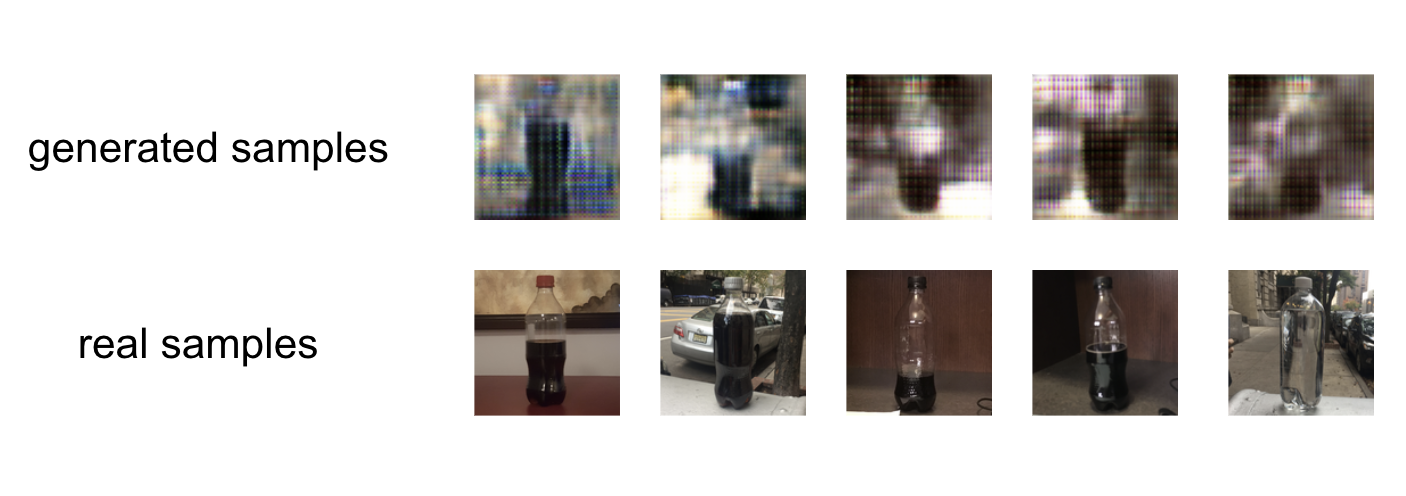

Although the generation quality is not good enough, we can still see the model is able to generate bottle images with different amount of liquid inside. Continue training will improve the generation quality.